                                
Maximizer finds its target agent:
Max Action:    Agent27 's opinion 0.5089331282511073 changed to 1
Min Action:    Agent25 's opinion 0.16691261141000213 changed to 0.7179647013923676
Network reaches equilibrium Polarization: 0.015229709169409321


C:\Users\xzhan176\AppData\Local\Temp\ipykernel_14780\1621945027.py:44: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.adjacency_matrix(nxG).todense()


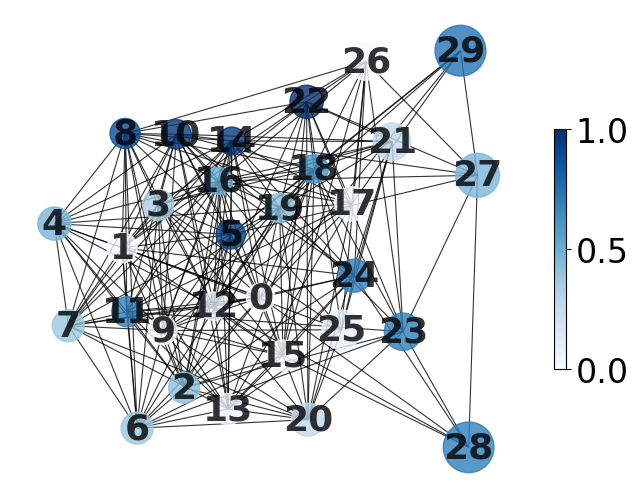

In [1]:
%run excute_nonZS_MaxMin.ipynb
%matplotlib inline
import csv
import statsmodels.api as sm
import pandas as pd

In [11]:
# x_values Normalizaion 
from sklearn.preprocessing import MinMaxScaler
def rescale(dic): # input x is a dictionary - sorted node index: value
    minmax_scale = MinMaxScaler(feature_range=(0, 1))
    x = list(dic.values())
    x = np.array(x)
    x = x.reshape(-1, 1)
    x_scale = minmax_scale.fit_transform(x).flatten()
    dic_scale = dict(zip(dic.keys(),x_scale))
    return dic_scale  # output

# Creat Metrics for Regression

################### create shortest path from all nodes to max selected node v1 ############
def shortest_pth(G, v1):
    nxG = nx.from_numpy_matrix(G)  
    paths = nx.single_source_shortest_path(nxG, v1)
    # the length of shortest path from v2 to v1
    lenths =[]
    for v in paths.items():
        lenth = len(v[1])
        lenths.append(lenth)  
    PathLen = dict(zip(paths.keys(),lenths))
    print("path_lenth",PathLen)
    return PathLen

def metrics(G, v1):

    nxG = nx.from_numpy_matrix(G) 
    # G = nx.karate_club_graph()
    print("_______________Degree Centrality_____________________________")  
    deg_centrality = nx.degree_centrality(nxG)
    sortedDict = sorted(deg_centrality.items(), key=lambda x:x[1])
    converted_dict = dict(sortedDict)
    # print(converted_dict)
    #print("                           ")
    print("_______________Closeness Rank_____________________________")
    close_centrality = nx.closeness_centrality(nxG)
    sortedDict1 = sorted(close_centrality.items(), key=lambda x:x[1])
    converted_dict1 = dict(sortedDict1)
    # print(converted_dict1)
    #print("                           ")
    print("_______________Page Rank_____________________________")
    pr = nx.eigenvector_centrality(nxG)
    sortedDict2 = sorted(pr.items(), key=lambda x:x[1])
    converted_dict2 = dict(sortedDict2)
    # print(converted_dict2)
    #print("                           ")
    print("_______________Opinion Extremity_____________________________")
    def gap(op, n):
        ones = np.ones((n, 1))
        x = op - (np.dot(np.transpose(op),ones)/n) * ones
        return abs(x)
    gap = gap(s,n)
    my_gap = {index: value for index, value in enumerate(gap)}
    sorting_gap = sorted(my_gap.items(), key=lambda x:x[1], reverse=True)
    sorted_gap = dict(sorting_gap)
    # print("opinion - mean")
    # print(sorted_gap)
    
    print("________________Shortest Path_____________________________")
    PathLen = shortest_pth(G, v1)
    
    
    # creat a dict node:shortest length to v1(max selected node)
    scaled_MinPath = rescale(PathLen) # rescale the shortest path to the range (0,1) for regression
    print("scaled path lenths",scaled_MinPath)
    # sorting all varibles based on the node index
    scaled_MinPaths_sort = dict(sorted(scaled_MinPath.items(), key=lambda x:x[0]))
    print("scaled_paths_sort",scaled_MinPaths_sort)
    
    converted_dict = dict(sorted(converted_dict.items(), key=lambda x:x[0]))
    converted_dict1 = dict(sorted(converted_dict1.items(), key=lambda x:x[0]))
    converted_dict2 = dict(sorted(converted_dict2.items(), key=lambda x:x[0]))
    sorted_gap = dict(sorted(sorted_gap.items(), key=lambda x:x[0]))
    
    return (converted_dict, converted_dict1, converted_dict2, sorted_gap, scaled_MinPaths_sort)

    


In [12]:
# Find the ground truth of Min's action - knowing Max chooses v1, what Min's action will be?
def actual_rank(s, n, v1, max_opinion):

    L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
    A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
    op = copy.copy(s)
    op[v1] = max_opinion
    all_1 = list(range(n))    # for all agent 
    C1 = [x for x in all_1 if x != v1]  # for the vertice that Maximizer has not touched
    innat_por = obj_polarization(A, s, n) # Calculate innate polarization
    results = []
    for v2 in C1:   
        (changed_opinion, por) = derivate_s(op,n,v2,A)   # find the best new_op option  
        por_1 = por - innat_por     # append the change of the polarization
        results.append((v2, por_1))
    results.append((v1,0)) # minimizer cannot choose v1, but we need all nodes for the dataframe
    actual_Y = dict(results) # now we have - node:polarization
    
    # most of v are in sequential order, but v1 might not be in order, so we need to sort it
    sorted_actual_Y = sorted(actual_Y.items(), key=lambda x:x[0])
    actual_Y_dict = dict(sorted_actual_Y)  # dictionary -  node:polarization
    print("actual_Y_dict",actual_Y_dict) 

    # create the rank of the Y values based on minimizer's choice 
    actual_Y_order = dict(sorted(actual_Y.items(), key=lambda x:x[1]))  #sort - list nodes in sequential of the polariz.

    node_ranks= dict(zip(actual_Y_order.keys(), all_1)) # dictionary -  node:polarization rank(replace polarz. with rank)
    actual_ranks = dict(sorted(node_ranks.items(), key=lambda x:x[0])) # sort - list node in sequential node index
    
    return (actual_Y_dict, actual_ranks)  # return two dictionary, 1. sequential node: polarization, 
                                                                # 2. seq. node: pol rank

In [13]:
for i in range(100):
    s = make_innat_opinions(n)
    G = make_random_network(n)
    (v1, v2, max_opinion, min_opinion, max_pol) = MaxMin_play(s,n,G)
    (converted_dict, converted_dict1, converted_dict2, sorted_gap, scaled_MinPaths_sort) = metrics(G, v1) 

    ##################################the actual rank based on polarization ####################
    (actual_Y_dict, actual_ranks) = actual_rank(s, n, v1, max_opinion)
     # rescale the polarization change to the range (0,1) for regression
    rescaled_dict = rescale(actual_Y_dict)


_______________Degree Centrality_____________________________
_______________Closeness Rank_____________________________
_______________Page Rank_____________________________
_______________Opinion Extremity_____________________________
________________Shortest Path_____________________________
path_lenth {27: 1, 5: 2, 14: 2, 16: 2, 22: 2, 23: 2, 26: 2, 28: 2, 29: 2, 1: 3, 2: 3, 3: 3, 4: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 12: 3, 13: 3, 15: 3, 18: 3, 19: 3, 0: 3, 11: 3, 17: 3, 21: 3, 24: 3, 20: 3, 25: 3}
scaled path lenths {27: 0.0, 5: 0.5, 14: 0.5, 16: 0.5, 22: 0.5, 23: 0.5, 26: 0.5, 28: 0.5, 29: 0.5, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 12: 1.0, 13: 1.0, 15: 1.0, 18: 1.0, 19: 1.0, 0: 1.0, 11: 1.0, 17: 1.0, 21: 1.0, 24: 1.0, 20: 1.0, 25: 1.0}
scaled_paths_sort {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.5, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 0.5, 15: 1.0, 16: 0.5, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 0